In [33]:
import numpy as np
def get_dataset(names,samples,binary=True,cross=False):
    data = []
    labels = []
    for name, sample in zip(names,samples):
        for s in sample:
            datum = np.load(f"data/preprocessed/data/{name}_{s}.npy")
            if binary:
                datum = np.concatenate((datum[:10], datum[-10:]))
                label = np.concatenate(([0 for _ in range(10)],[1 for _ in range(10)]))
            else:
                datum = datum = np.concatenate((datum[:10], datum[20:30], datum[-10:]))
                label = np.concatenate(([0 for _ in range(10)],[1 for _ in range(10)], [2 for _ in range(10)]))
            data.append(datum)
            labels.append(label)
    groups = []
    if cross:
        for i in range(len(names)):
            for _ in range(data[i].shape[0] * len(samples[i])):
                groups.append(i)
    else:
        num_per = 20 if binary else 30
        for i in range(len(data)):
            for _ in range(num_per):
                groups.append(i)
    groups = np.array(groups)
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels, groups
    

In [87]:
names = ["onno", "yoyo", "emma"]
samples = [[1,2,3,4,5],[1,2,3,4,5,6],[1,2]]
data, labels, groups = get_dataset(names,samples,binary=True,cross=False)
print(data.shape)
print(labels.shape)
print(groups.shape)

(260, 16, 1000)
(260,)
(260,)


In [88]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1]


In [89]:
print(groups)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12]


In [90]:
unique_labels, counts = np.unique(labels,return_counts=True)
print(np.asarray((unique_labels, counts)).T)

[[  0 130]
 [  1 130]]


In [38]:
from classify import classify_sklearn
from classify import FeatureWrapper
from sklearn.model_selection import LeaveOneGroupOut

def feature_select(data, y, groups, model, channels, features, sfreq, normalize=True):
    wrapper = FeatureWrapper()
    X = []
    for i, sample in enumerate(data):
        output = wrapper.compute_features(sample,i,sfreq,channels,desired_features=features)
        X.append(output)
    X = np.array(X)
    print(X.shape)
    accuracy = classify_sklearn(X,y,model,normalize=normalize,cv_splitter=LeaveOneGroupOut(),groups=groups)['mean_accuracy']
    next_accuracy = accuracy 
    kept = channels.copy()
    while next_accuracy >= accuracy and len(kept) > 1:
        accuracies = []
        for i in range(len(kept)):
            temp_kept = kept[:i] + kept[i+1:]
            #print(temp_kept)
            temp_x = X[:,temp_kept,:]
            #print(temp_x.shape)
            #print()
            temp_accuracy = classify_sklearn(temp_x,y,model,normalize=normalize,cv_splitter=LeaveOneGroupOut(),groups=groups)['mean_accuracy']
            accuracies.append(temp_accuracy)
        accuracies = np.array(accuracies)
        next_accuracy = np.max(accuracies)
        j = np.argmax(accuracies)
        if next_accuracy >= accuracy:
            accuracy = next_accuracy
            kept.pop(j)
            print(f"For channels {kept}, accuracy of {accuracy}")
    print(f"Final accuracy: {accuracy}")
    return kept
    

In [91]:
from sklearn.model_selection import LeaveOneGroupOut
from classify import Optimizer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from classify import classify_sklearn
from classify import FeatureWrapper
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from skopt import BayesSearchCV
from skopt.space import Real, Integer

splitter = LeaveOneGroupOut()
all_accuracies = []
all_differences = []
all_mean_differences = []
wrapper = FeatureWrapper()
all_preds = []
for train, test in splitter.split(data,groups=groups):
    print(f"Train indices: {train}")
    print(f"Test indices: {test}")
    data_train = data[train]
    labels_train = labels[train]
    data_test = data[test]
    labels_test = labels[test]
    train_groups = groups[train]
    selected_channels = [i for i in range(16)]
    #desired_features = ["alpha_bandpower", "beta_bandpower", "theta_bandpower", "hjorth_mobility", "hjorth_complexity","hjorth_activity", "sample_entropy", "permutation_entropy"]
    desired_features = ["alpha_bandpower", "beta_bandpower", "theta_bandpower"]
    #selected_channels = feature_select(data_train,labels_train,train_groups,SVC(),selected_channels,desired_features,125)
    print(selected_channels)
    processed_samples_test = []
    for i, sample in zip(test,data_test):
        features = wrapper.compute_features(sample,i,125,selected_channels,desired_features=desired_features)
        processed_samples_test.append(features)
    processed_samples_test = np.array(processed_samples_test)
    print(processed_samples_test.shape)
    processed_samples = []
    for i, sample in zip(train,data_train):
        features = wrapper.compute_features(sample,i,125,selected_channels,desired_features=desired_features)
        processed_samples.append(features)
    processed_samples = np.array(processed_samples)
    print(processed_samples.shape)
    X_train = np.reshape(processed_samples,(processed_samples.shape[0],-1))
    X_test = np.reshape(processed_samples_test,(processed_samples_test.shape[0],-1))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    search_space = {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'gamma': Real(1e-6, 1e+1, prior='log-uniform')
    }   
    opt = BayesSearchCV(
        estimator=SVC(kernel='rbf'),
        search_spaces=search_space,
        n_iter=32, 
        cv=LeaveOneGroupOut(),
        n_jobs=-1,
        scoring='accuracy', 
        verbose=0,
        random_state=42
    )
    #opt.fit(X_train, labels_train, groups=train_groups)
    #print("Best hyperparameters:", opt.best_params_)
    #print("Best CV accuracy:", opt.best_score_)
    #model = SVC(kernel='rbf',**opt.best_params_)
    model = SVC()
    model.fit(X_train,labels_train)
    y_pred = model.predict(X_test)
    #y_pred = np.array([round(pred) if round(pred) >= 0 else 0 for pred in y_pred])
    all_preds.extend(y_pred)
    accuracy = accuracy_score(labels_test,y_pred)
    precision = precision_score(labels_test,y_pred,average='weighted')
    recall = recall_score(labels_test,y_pred,average='weighted')
    f1 = f1_score(labels_test,y_pred,average='weighted')
    differences = [abs(pred-real) for pred, real in zip(y_pred,labels_test)]
    all_differences.extend(differences)
    mean_difference = np.mean(differences).item()
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {accuracy}")
    print(f"Recall: {accuracy}")
    print(f"F1: {accuracy}")
    print(f"Difference: {mean_difference}")
    all_accuracies.append(accuracy)
    all_mean_differences.append(mean_difference)
print(f"Average accuracy: {np.mean(all_accuracies)}")
print(f"Average difference: {np.mean(all_mean_differences)}")


Train indices: [ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259]
Test indic

c:\Users\matth\anaconda3\envs\neurotech\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [92]:
print(f"Average accuracy: {np.mean(all_accuracies)}")
print(all_accuracies)
print(f"Average difference: {np.mean(all_mean_differences)}")
print(all_mean_differences)
print(f"Median difference: {np.median(all_differences)}")
print(f"Max difference: {np.max(all_differences)}")
num_under = np.sum([1 if diff <= 1.0 else 0 for diff in all_differences]).item()
print(f"Number of samples predicted within 1 of label: {num_under} out of {len(all_differences)}")

Average accuracy: 0.8999999999999999
[0.55, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 0.75, 0.5]
Average difference: 0.1
[0.45, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.25, 0.5]
Median difference: 0.0
Max difference: 1
Number of samples predicted within 1 of label: 260 out of 260


In [93]:
all_preds = np.array(all_preds)
print(all_preds.shape)
expected = np.array([0,1]*13)
all_pred_splits = np.array(np.split(all_preds,26))
print(all_pred_splits.shape)
all_pred_splits = np.array([np.argmax(np.bincount(preds)) for preds in all_pred_splits])
print(all_pred_splits.shape)
print(all_pred_splits)
accuracy = accuracy_score(expected,all_pred_splits)
print(accuracy)

(260,)
(26, 10)
(26,)
[1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0]
0.8846153846153846


In [94]:
unique_preds, counts = np.unique(all_preds,return_counts=True)
print(np.asarray((unique_preds, counts)).T)

[[  0 134]
 [  1 126]]


In [95]:
buckets = [[] for _ in range(2)]
for difference, label in zip(all_differences,labels):
    buckets[label].append(difference)
buckets = np.array(buckets)
for i, diff_list in enumerate(buckets):
    print(f"Mean difference for class {i}: {np.mean(diff_list)}")
    print(f"Median difference for class {i}: {np.median(diff_list)}")
    num_under = np.sum([1 if diff <= 1.0 else 0 for diff in diff_list]).item()
    print(f"Number of samples predicted within 1 of label for class {i}: {num_under} out of {len(diff_list)}")
    num_equal = np.sum([1 if diff == 0 else 0 for diff in diff_list]).item()
    print(f"Number of samples predicted correct of label for class {i}: {num_equal} out of {len(diff_list)}")
    print()

Mean difference for class 0: 0.08461538461538462
Median difference for class 0: 0.0
Number of samples predicted within 1 of label for class 0: 130 out of 130
Number of samples predicted correct of label for class 0: 119 out of 130

Mean difference for class 1: 0.11538461538461539
Median difference for class 1: 0.0
Number of samples predicted within 1 of label for class 1: 130 out of 130
Number of samples predicted correct of label for class 1: 115 out of 130



In [55]:
import numpy as np
import matplotlib.pyplot as plt

def plot_eeg_by_channel(eeg_data, labels):
    channel_list = ['FP1','FP2','AF3','AF4','F3','F4','F7','F8','C3','C4','T5','T6','PO3','PO4','O1','O2']
    num_samples, num_channels, num_features = eeg_data.shape
    assert num_features == 2, "Expected exactly two features: alpha and beta bandpower"
    classes = np.unique(labels)
    colors = plt.cm.get_cmap(lut=len(classes))
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    axs = axs.ravel()

    for ch in range(num_channels):
        ax = axs[ch]
        for idx, cls in enumerate(classes):
            mask = labels == cls
            alpha = eeg_data[mask, ch, 0]
            beta = eeg_data[mask, ch, 1]
            ax.scatter(alpha, beta, color=colors(idx), label=f'Class {cls}', alpha=0.7)
        ax.set_title(f'{channel_list[ch]}')
        ax.set_xlabel('Alpha Power')
        ax.set_ylabel('Beta Power')
        ax.grid(True)

    axs[0].legend()
    plt.tight_layout()
    #plt.savefig("data_binary.pdf")
    plt.show()


In [56]:
#from classify import FeatureWrapper
#wrapper = FeatureWrapper()
feature_matrix = []
for i, sample in enumerate(data):
    features = wrapper.compute_features(sample,i,125,[i for i in range(16)],desired_features=["beta_bandpower","alpha_bandpower"])
    feature_matrix.append(features)
feature_matrix = np.array(feature_matrix)
num_samples, num_channels, num_features = feature_matrix.shape
feature_matrix = np.reshape(feature_matrix,(feature_matrix.shape[0],-1))
scaler = MinMaxScaler(feature_range=(-1, 1))
feature_matrix = scaler.fit_transform(feature_matrix)
feature_matrix = feature_matrix.reshape(num_samples, num_channels, num_features)
print(feature_matrix.shape)

(260, 16, 2)


C:\Users\matth\AppData\Local\Temp\ipykernel_3576\3183922957.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(lut=len(classes))


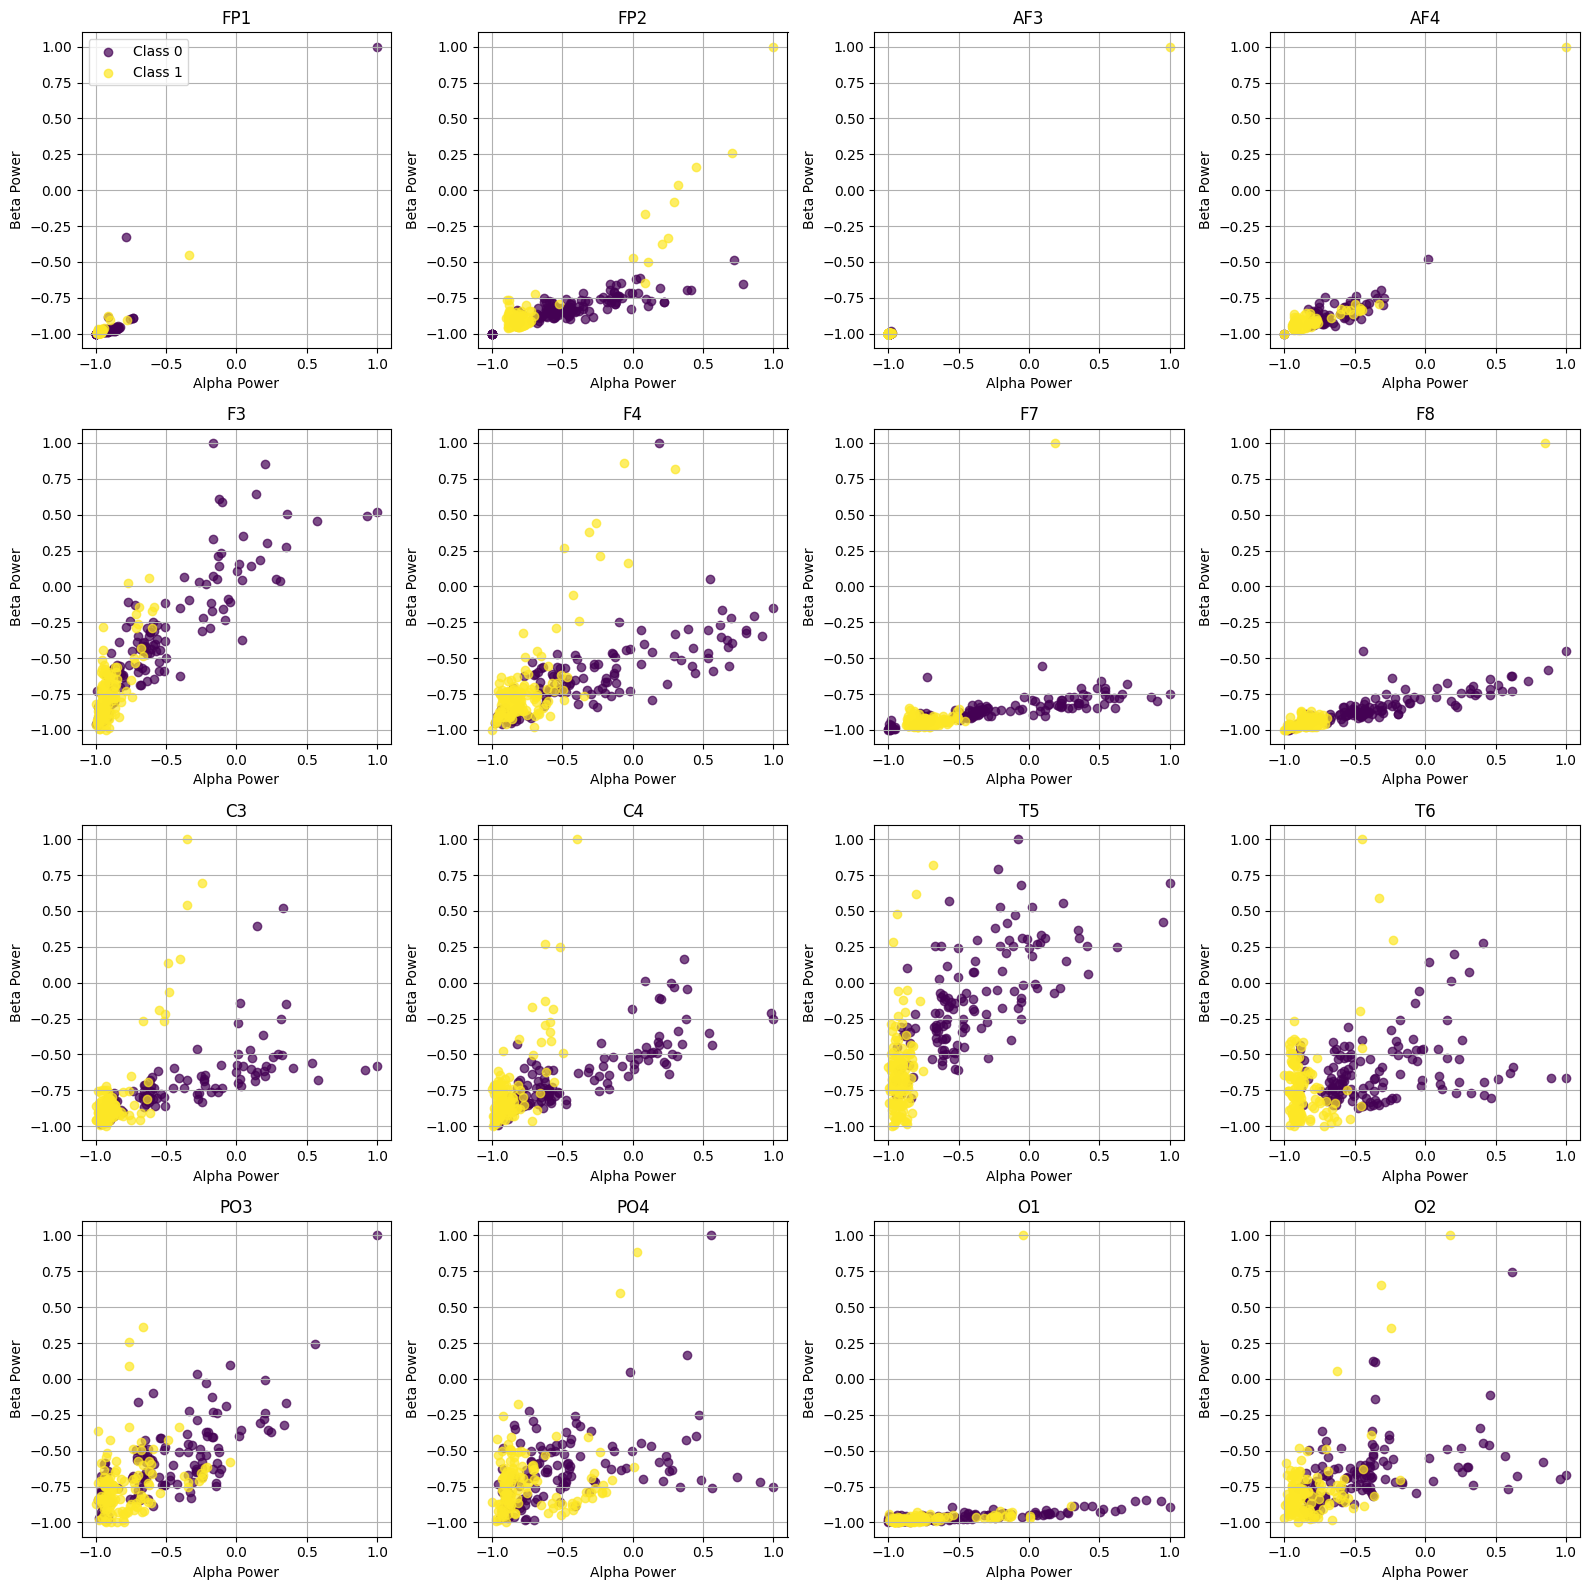

In [57]:
plot_eeg_by_channel(feature_matrix,labels)